
# RNN Example for Time Series

In [ ]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly


In [ ]:
df = pd.read_csv('../Data/RSCCASN.csv',index_col='DATE',parse_dates=True)

In [ ]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [ ]:
df.columns = ['Sales']

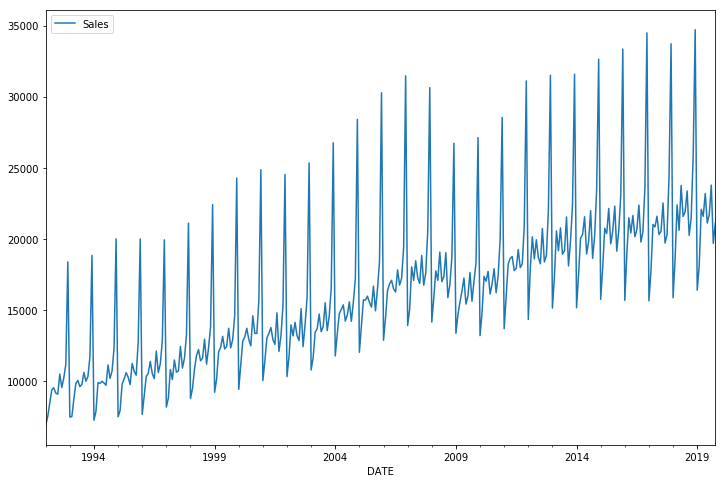

In [ ]:
df.plot(figsize=(12,8))

## Train Test Split

In [ ]:
len(df)

334

Data is monthly, let's forecast 1.5 years into the future.

In [ ]:
len(df)- 18

316

In [ ]:
test_size = 18

In [ ]:
test_ind = len(df)- test_size

In [ ]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [ ]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [ ]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


## Scale Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler()

In [ ]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# Let's redefine to get 12 months back and then predict the next month out (scaled_train= source of the X and Y)
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [ ]:
# What does the first batch look like?
X,y = generator[0]

In [ ]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


In [ ]:
#X

In [ ]:
#y

In [ ]:
#scaled_train

### Create the Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
# We're only using one feature in our time series
n_features = 1

In [ ]:
# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and creating a Validation Generator

NOTE: The scaled_test dataset size MUST be greater than your length chosen for your batches. 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [ ]:
# fit model
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 2s 8ms/step - loss: 0.0235 - val_loss: 0.0505
Epoch 2/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0142 - val_loss: 0.0169
Epoch 3/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0061 - val_loss: 0.0025
Epoch 4/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0068 - val_loss: 0.0122
Epoch 5/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 6/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 7/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 8/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0013 - val_loss: 6.2361e-04
Epoch 9/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0014 - val_loss: 0.0042
Epoch 10/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0020 - val_loss: 0.

In [ ]:
losses = pd.DataFrame(model.history.history)

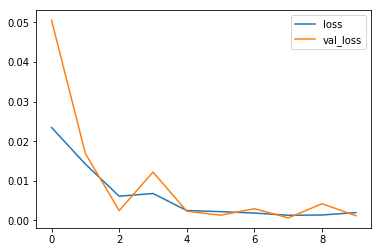

In [ ]:
losses.plot()

In [ ]:
amir=12

In [ ]:
-amir

-12

## Evaluate on Test Data

In [ ]:
#My test prediction going to start of as an empty list and then I need to figure out my first training 
#batch whats it going to look like. its the very last batch points from my scaled training set.So, I am going to 
#grab what is essentially the last 12 months of my training set to predict one month into the future
#which by defination is the first point in my test set.

#then we reshape it (1 item in each batch, in 12 month, 1(we have one feature to predict))


test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value (1:, drops the very first value in that current batch)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

## Inverse Transformations and Compare

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

C:\Users\Amir\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,22170.816315
2018-06-01,21589,20916.496074
2018-07-01,21919,21114.991898
2018-08-01,23381,23115.812733
2018-09-01,20260,20311.805769
2018-10-01,21473,20918.609006
2018-11-01,25831,25133.540313
2018-12-01,34706,35130.678542
2019-01-01,16410,16556.444709


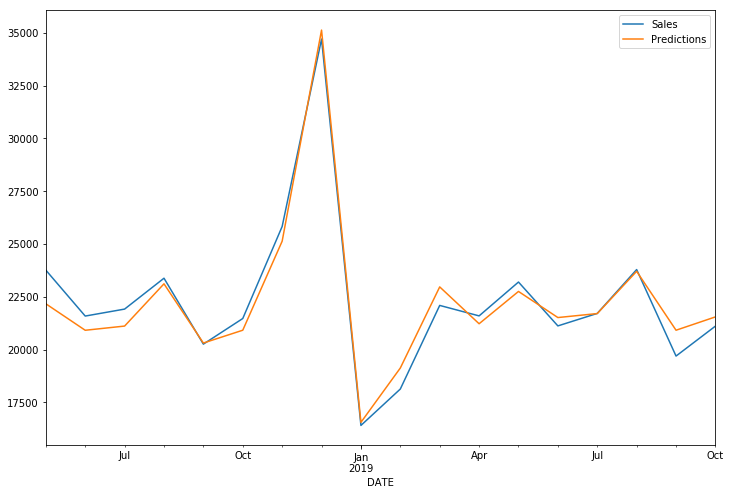

In [ ]:
test.plot(figsize=(12,8))

# Retrain and Forecasting

In [ ]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [ ]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [ ]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=10)

Epoch 1/10
322/322 [==============================] - 3s 9ms/step - loss: 0.0227
Epoch 2/10
322/322 [==============================] - 3s 8ms/step - loss: 0.0107
Epoch 3/10
322/322 [==============================] - 3s 8ms/step - loss: 0.0057
Epoch 4/10
322/322 [==============================] - 3s 8ms/step - loss: 0.0023
Epoch 5/10
322/322 [==============================] - 3s 9ms/step - loss: 0.0017
Epoch 6/10
322/322 [==============================] - 3s 8ms/step - loss: 0.0013
Epoch 7/10
322/322 [==============================] - 3s 9ms/step - loss: 0.0013
Epoch 8/10
322/322 [==============================] - 3s 8ms/step - loss: 0.0026
Epoch 9/10
322/322 [==============================] - 3s 9ms/step - loss: 0.0014
Epoch 10/10
322/322 [==============================] - 3s 8ms/step - loss: 0.0014


In [ ]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
forecast = scaler.inverse_transform(forecast)

### Creating new timestamp index with pandas.

In [ ]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [ ]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [ ]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [ ]:
forecast_df

,Forecast
2019-11-01,27177.900367
2019-12-01,37993.198309
2020-01-01,17586.562598
2020-02-01,19417.961366
2020-03-01,23161.123401
2020-04-01,22668.214130
2020-05-01,24276.221571
2020-06-01,22250.817167
2020-07-01,22808.094543
2020-08-01,24881.965059


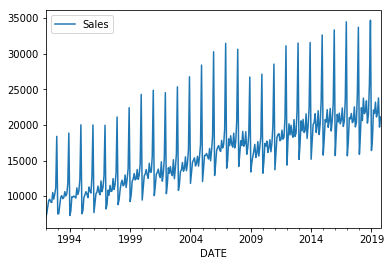

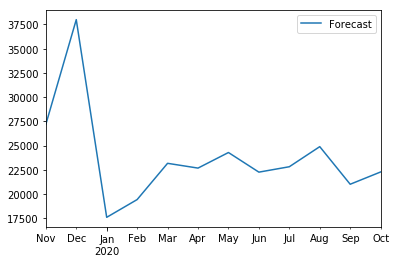

In [ ]:
df.plot()
forecast_df.plot()

### Joining pandas plots

https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure

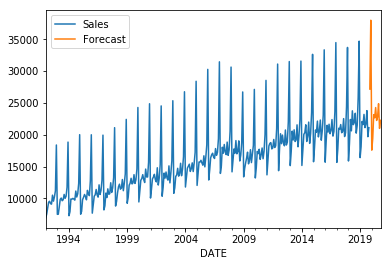

In [ ]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576, 611)

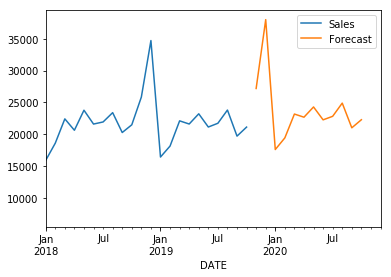

In [ ]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')

# Great Job!